In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns

In [2]:
D_RANGE = np.linspace(0,1,1000)

In [3]:
# chance = 0.5  # between 0 and 1
# y = chance + (1-chance) / (1 + np.exp(-k*(x-x0)))

def psychometric_func(x, alpha, beta, chance=0.5):
    """psychometric function"""
    return chance + (1-chance) / (1 + np.exp( -(x - alpha) / beta) )

In [18]:
def inspect_fits(fits_source_df,
                 fits_df,
                 net_name,
                 method,
                 source_dataset,
                 d_range=D_RANGE,
                 ax_arr=None,
                 figsize=(12, 4),
                 ylim=(0.4, 1.05),
                 axes_title=True,
                 suptitle=True,
                 xylabel=True,
                 threshold_markers=True
                ):
    this_fits_source_df = fits_source_df[
        (fits_source_df.net_name == net_name) &
        (fits_source_df.method == method) & 
        (fits_source_df.source_dataset == source_dataset)       
    ]
    this_fits_df = fits_df[
        (fits_df.net_name == net_name) &
        (fits_df.method == method) & 
        (fits_df.source_dataset == source_dataset)
    ]
    
    if ax_arr is None:
        fig, ax_arr = plt.subplots(1, 4, figsize=figsize)
        ax_arr = ax_arr.ravel()
    else:
        fig = None

    for set_size_ind, set_size in enumerate(this_fits_df.set_size.unique()):
        source_set_size_df = this_fits_source_df[
            this_fits_source_df.set_size == set_size
        ]
        fits_set_size_df = this_fits_df[
            this_fits_df.set_size == set_size
        ]

        for net_number_ind, net_number in enumerate(source_set_size_df.net_number.unique()):
            source_net_num_df = source_set_size_df[
                source_set_size_df.net_number == net_number
            ]
            fits_net_num_df = fits_set_size_df[
                fits_set_size_df.net_number == net_number
            ]

            discrim_pct = source_net_num_df.discrim_pct.values
            acc = source_net_num_df.accuracy.values

            if len(fits_net_num_df) > 0:
                ax = ax_arr[set_size_ind]
                ax.plot(discrim_pct, acc, marker='o', linestyle='None')

                if threshold_markers:
                    ax.plot(fits_net_num_df['discrim_threshold'], 
                            fits_net_num_df['threshold_acc'], 
                            marker='x',
                            linestyle='None')

                ax.plot(d_range, 
                        psychometric_func(d_range, 
                                          fits_net_num_df.alpha.values.item(),
                                          fits_net_num_df.beta.values.item()))

        if axes_title:
            ax.set_title(f"set size: {set_size}")
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_ylim(ylim)

    if xylabel:
        # add a big axis, hide frame
        big_ax = fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.grid(False)

        big_ax.set_xlabel('target-distractor discriminability (%)')
        big_ax.set_ylabel('accuracy')

    if suptitle and fig:
        suptitle = fig.suptitle(f'{net_name} trained on {source_dataset}', y=0.95)

    if fig:
        fig.tight_layout()

    return fig, suptitle

In [5]:
SOURCE_DATASETS_TO_USE = (
    'None',
    'search stimuli (classify)',
    'ImageNet',
    'Stylized ImageNet',
    'DomainNet, Clipart domain',
)

NET_NAMES = (
    'alexnet',
    'VGG16'
)

In [6]:
RESULTS_ROOT = pyprojroot.here() / 'results' / 'searchstims' / 'source_data' / 'discriminability'

In [7]:
STIM_TYPES = (
    'rvg',
    'tvt'
)

In [8]:
source_fits_dfs = {}
fits_dfs = {}

for stim_type in STIM_TYPES:
    source_fits_dfs[stim_type] = pd.read_csv(RESULTS_ROOT / f'source_fits_{stim_type}.csv')
    fits_dfs[stim_type] = pd.read_csv(RESULTS_ROOT / f'fits_{stim_type}.csv')

## what do the fits look like?

In [9]:
sns.set()

#### Inspect fits of discrimination experiment where distractors are Vertical T and target is T rotated 90 degrees 
where we vary rotation of target T

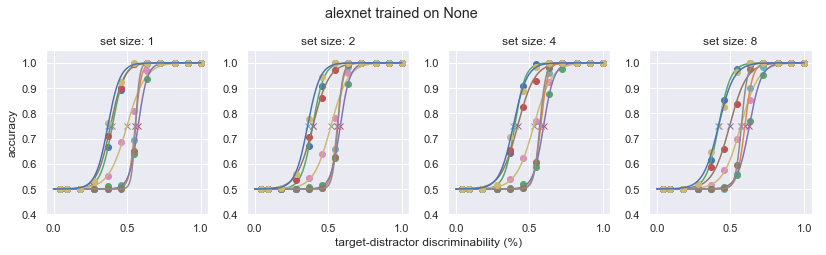

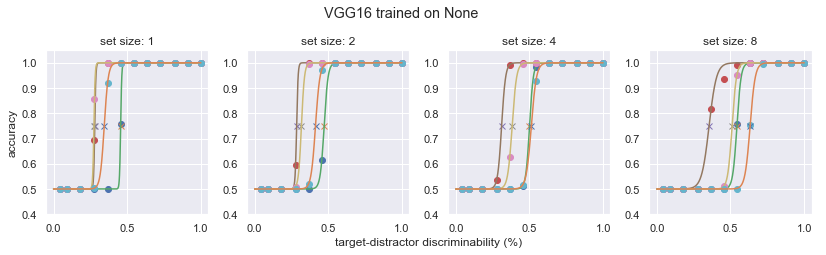

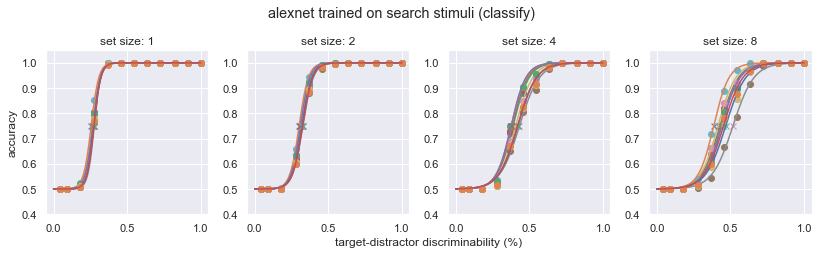

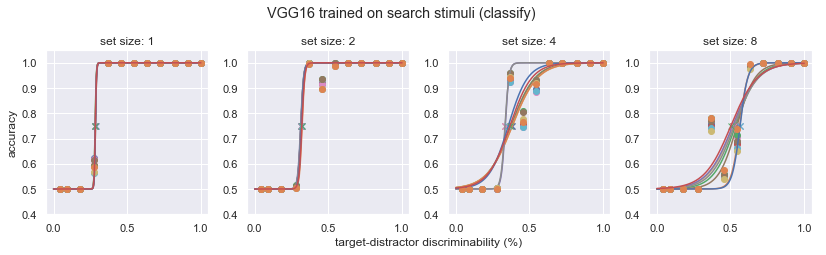

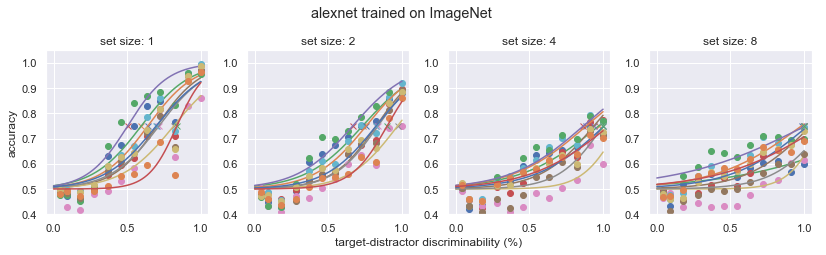

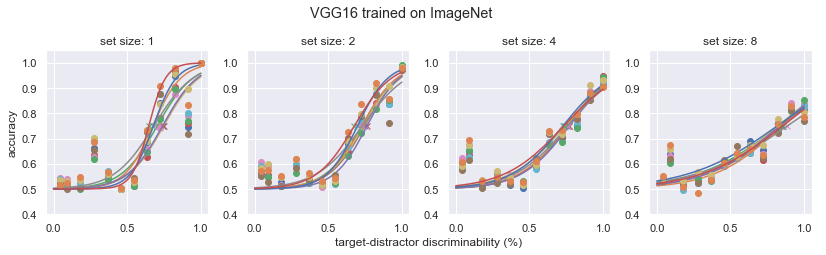

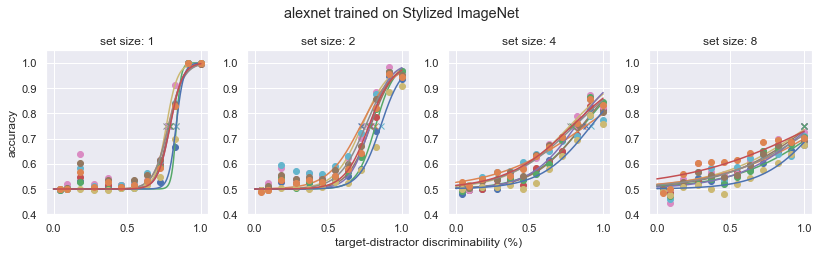

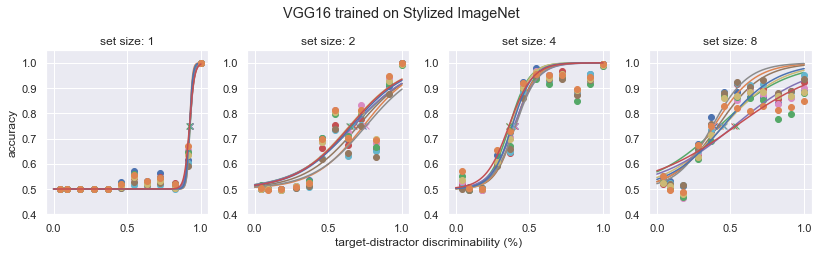

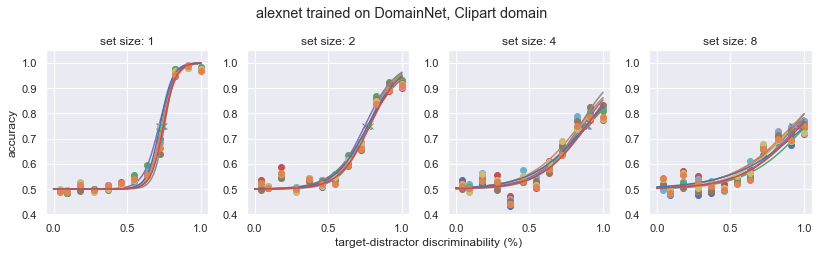

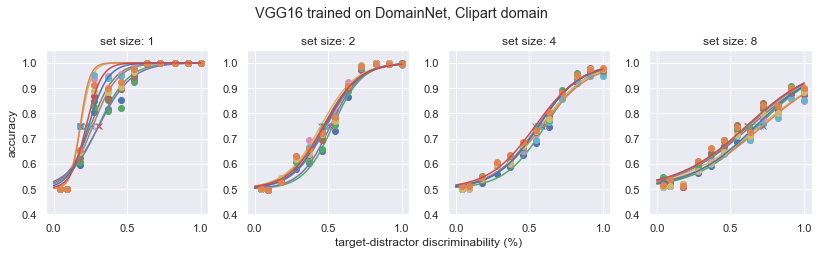

In [10]:
for source_dataset in SOURCE_DATASETS_TO_USE:
    if source_dataset == 'None':
        method = 'initialize'
    else:
        method = 'transfer'

    for net_name in NET_NAMES:
        inspect_fits(fits_source_df=source_fits_dfs['tvt'],
                     fits_df=fits_dfs['tvt'],
                     net_name=net_name,
                     method=method,
                     source_dataset=source_dataset)

/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:

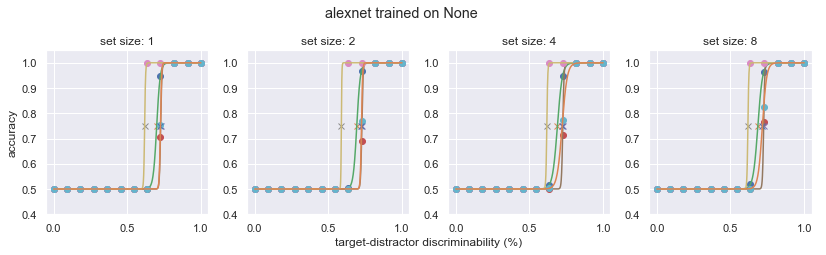

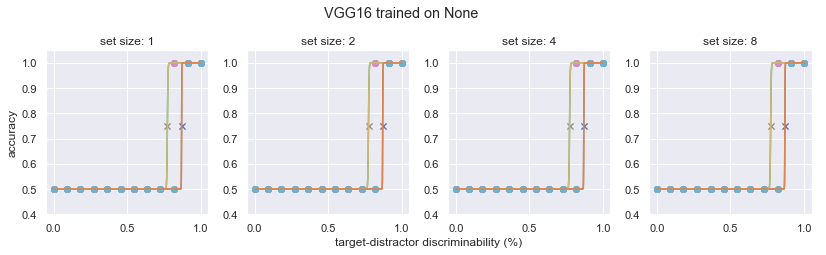

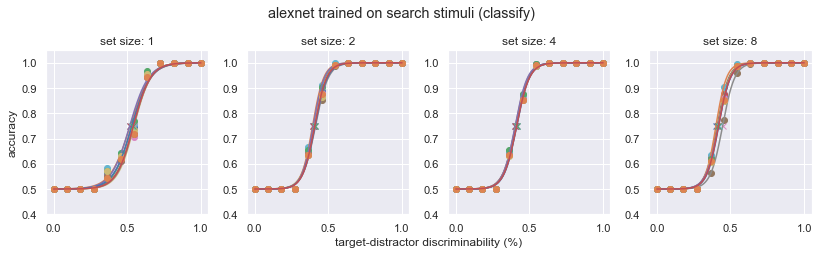

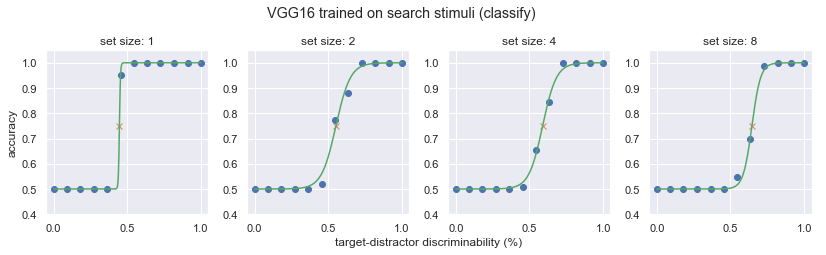

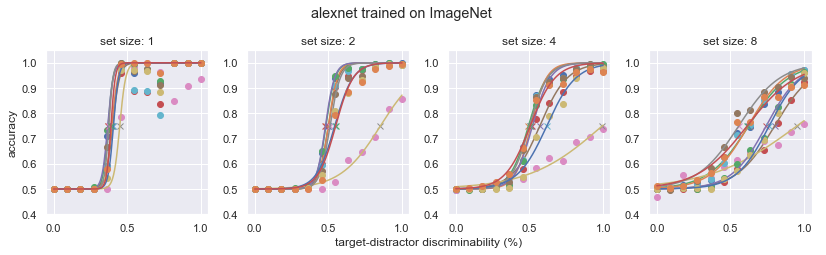

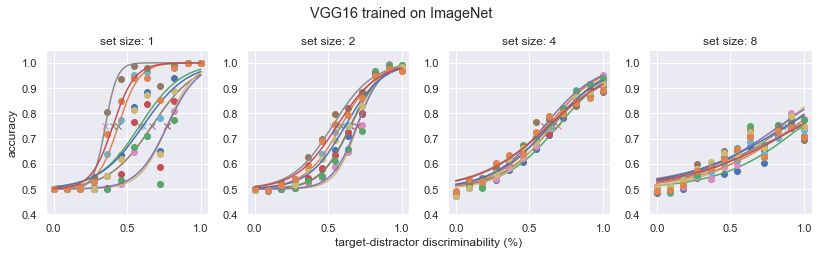

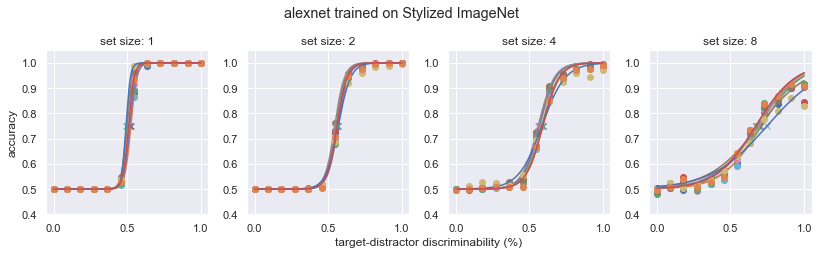

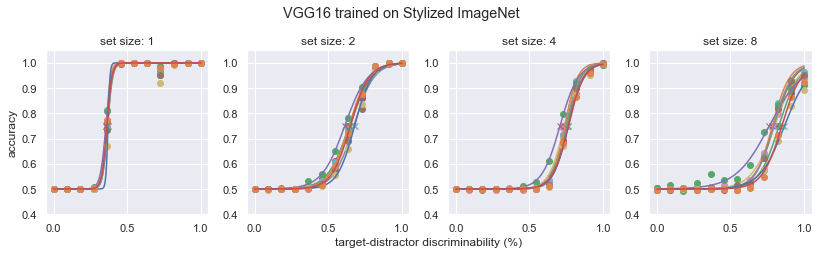

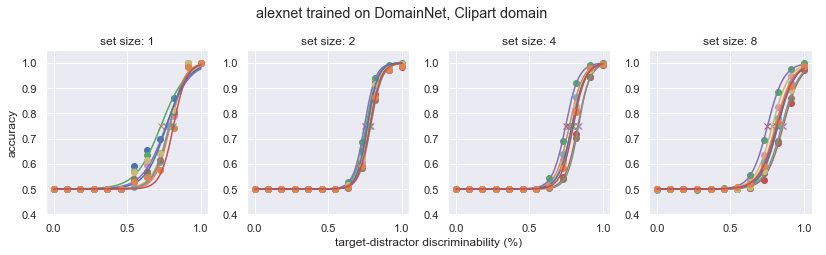

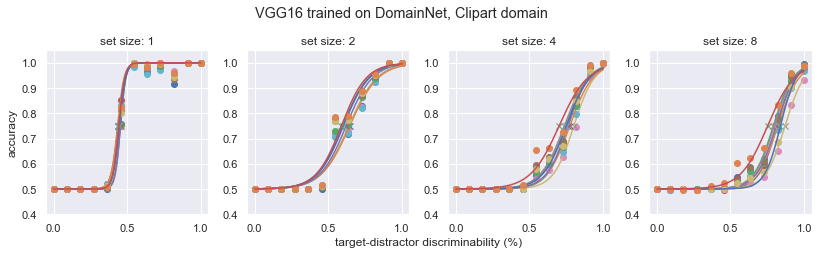

In [11]:
for source_dataset in SOURCE_DATASETS_TO_USE:
    if source_dataset == 'None':
        method = 'initialize'
    else:
        method = 'transfer'

    for net_name in NET_NAMES:
        inspect_fits(fits_source_df=source_fits_dfs['rvg'],
                     fits_df=fits_dfs['rvg'],
                     net_name=net_name,
                     method=method,
                     source_dataset=source_dataset)

In [15]:
sns.set(
    context='paper',
    font_scale=1.75,
)

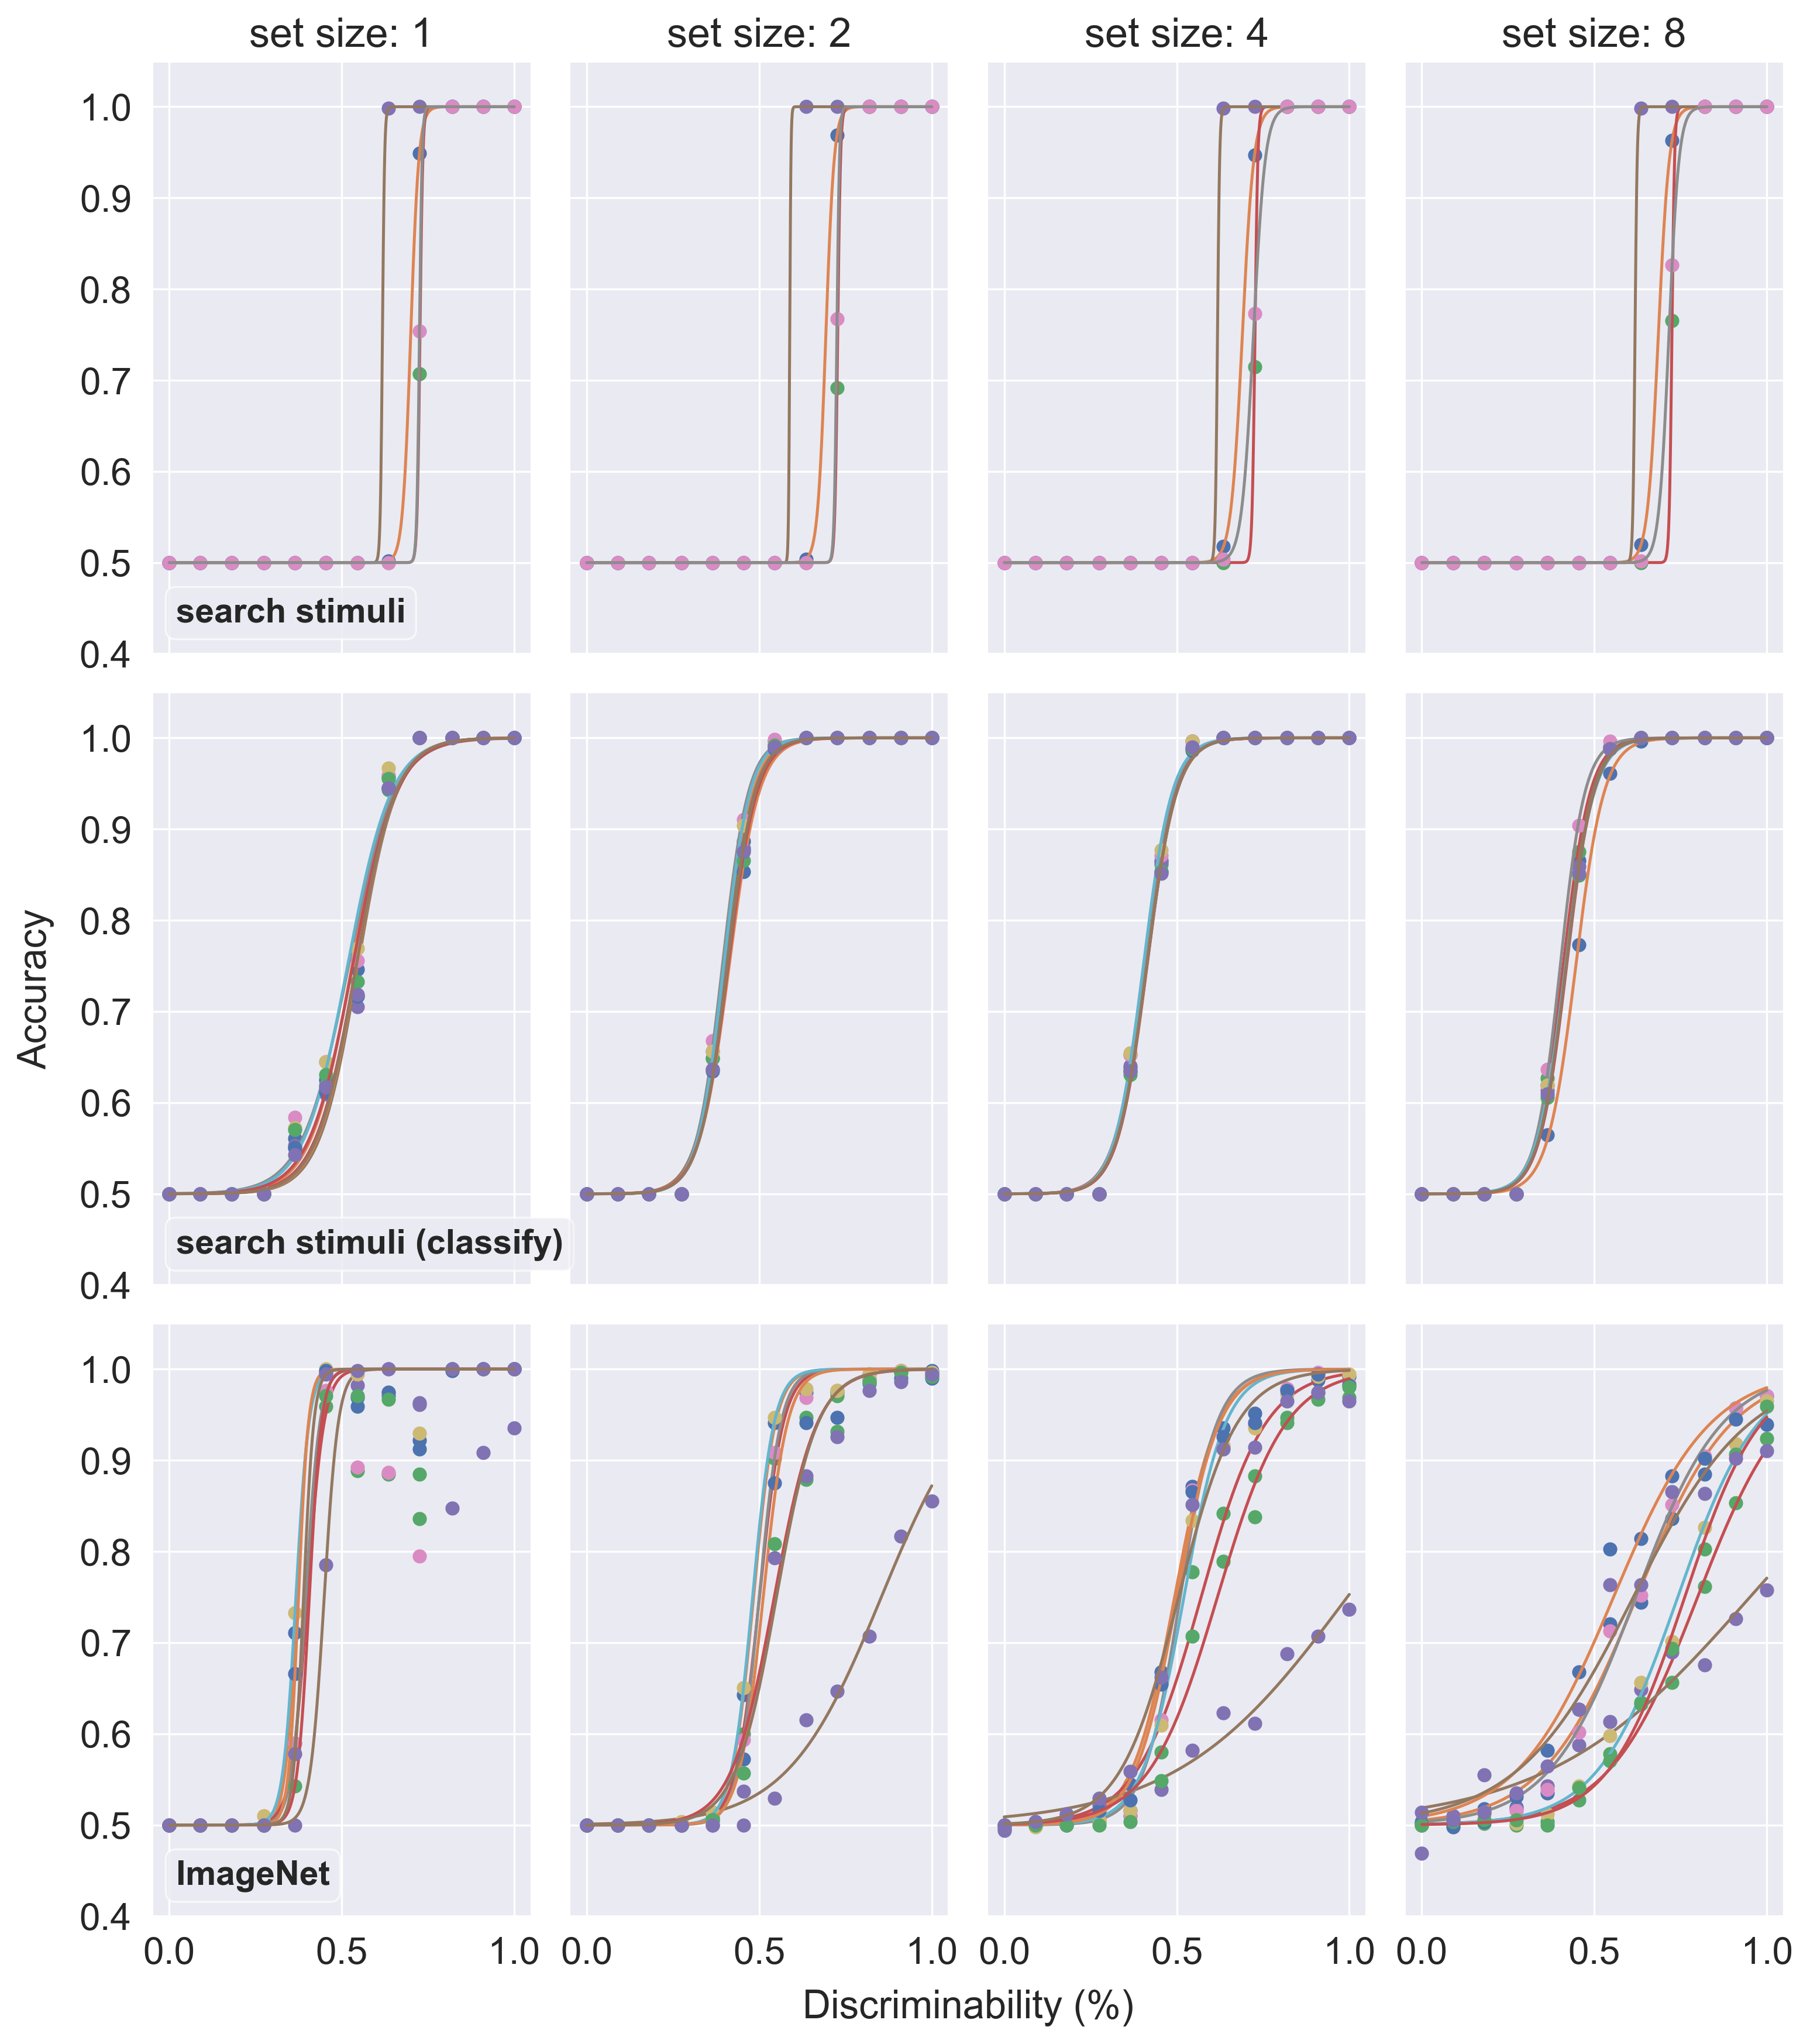

In [19]:
save_dst = 'docs/paper/figures/experiment-1/discriminability'

SOURCE_DATASET_TO_PLOT = (
    'None',
    'search stimuli (classify)',
    'ImageNet',
)

n_row, n_col = len(SOURCE_DATASET_TO_PLOT), len(fits_dfs['rvg'].set_size.unique())

FIGSIZE = (12, 14)
DPI = 300
fig, ax_arr = plt.subplots(n_row, n_col, figsize=FIGSIZE, dpi=DPI)

text_handles = []
for row_ind, source_dataset in enumerate(SOURCE_DATASET_TO_PLOT):
    if source_dataset == 'None':
        method = 'initialize'
    else:
        method = 'transfer'

    row_ax_arr = ax_arr[row_ind, :]

    _ = inspect_fits(fits_source_df=source_fits_dfs['rvg'],
                     fits_df=fits_dfs['rvg'],
                     net_name='alexnet',
                     method=method,
                     source_dataset=source_dataset,
                     ax_arr=row_ax_arr,
                     axes_title=False,
                     suptitle=False,
                     xylabel=False,
                     threshold_markers=False)
    
    if row_ind == 0:
        for ax, set_size in zip(row_ax_arr, (1, 2, 4, 8)):
            ax.set_title(f'set size: {set_size}')
    
    if source_dataset == 'None':
        source_dataset_for_lbl = 'search stimuli'
    else:
        source_dataset_for_lbl = source_dataset

    bbox_kwargs = dict(boxstyle='round', facecolor=row_ax_arr[0].get_facecolor(), alpha=0.5)
    h = row_ax_arr[0].text(0.02, 0.435, source_dataset_for_lbl, fontweight='bold', fontsize=14, bbox=bbox_kwargs)
    text_handles.append(h)

for h in text_handles:
    fig.texts.append(h)
    
for ax_ in ax_arr[:, 1:].ravel():
    ax_.set_yticklabels([])

for ax_ in ax_arr[:-1, :].ravel():
    ax_.set_xticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.065)

# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

big_ax.set_xlabel("Discriminability (%)", labelpad=30, fontsize=16);
big_ax.set_ylabel('Accuracy', labelpad=40, fontsize=16)


for ext in ('svg', 'png'):
    source_dataset = source_dataset.replace(' ', '-')
    fig.savefig(
        pyprojroot.here() / save_dst / f'alexnet-psychometric-func-fits.{ext}',
        bbox_inches='tight',
    )

In [20]:
df_all = []

for stim_type, df in fits_dfs.items():
    df['stimulus'] = stim_type
    df_all.append(df)

df_all = pd.concat(df_all)

SOURCE_DATASETS_TO_USE = (
    'None',
    'search stimuli (classify)',
    'ImageNet',
)

df_all = df_all[df_all['source_dataset'].isin(SOURCE_DATASETS_TO_USE)]

df_all.loc[df_all['source_dataset'] == 'None', 'source_dataset'] = 'search stimuli'

In [21]:
palette = {
    'search stimuli': (0.4, 0.7607843137254902, 0.6470588235294118),
    'ImageNet': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
    'search stimuli (classify)': (1.0, 0.8509803921568627, 0.1843137254901961),
}

In [23]:
sns.set(
    context='paper',
    font_scale=1.75,
)

In [24]:
df_all = df_all.rename(columns={'source_dataset':'Source Dataset'})
df_all.stimulus = df_all.stimulus.map({'rvg': 'RV v. GV', 'tvt':'T v. T'})

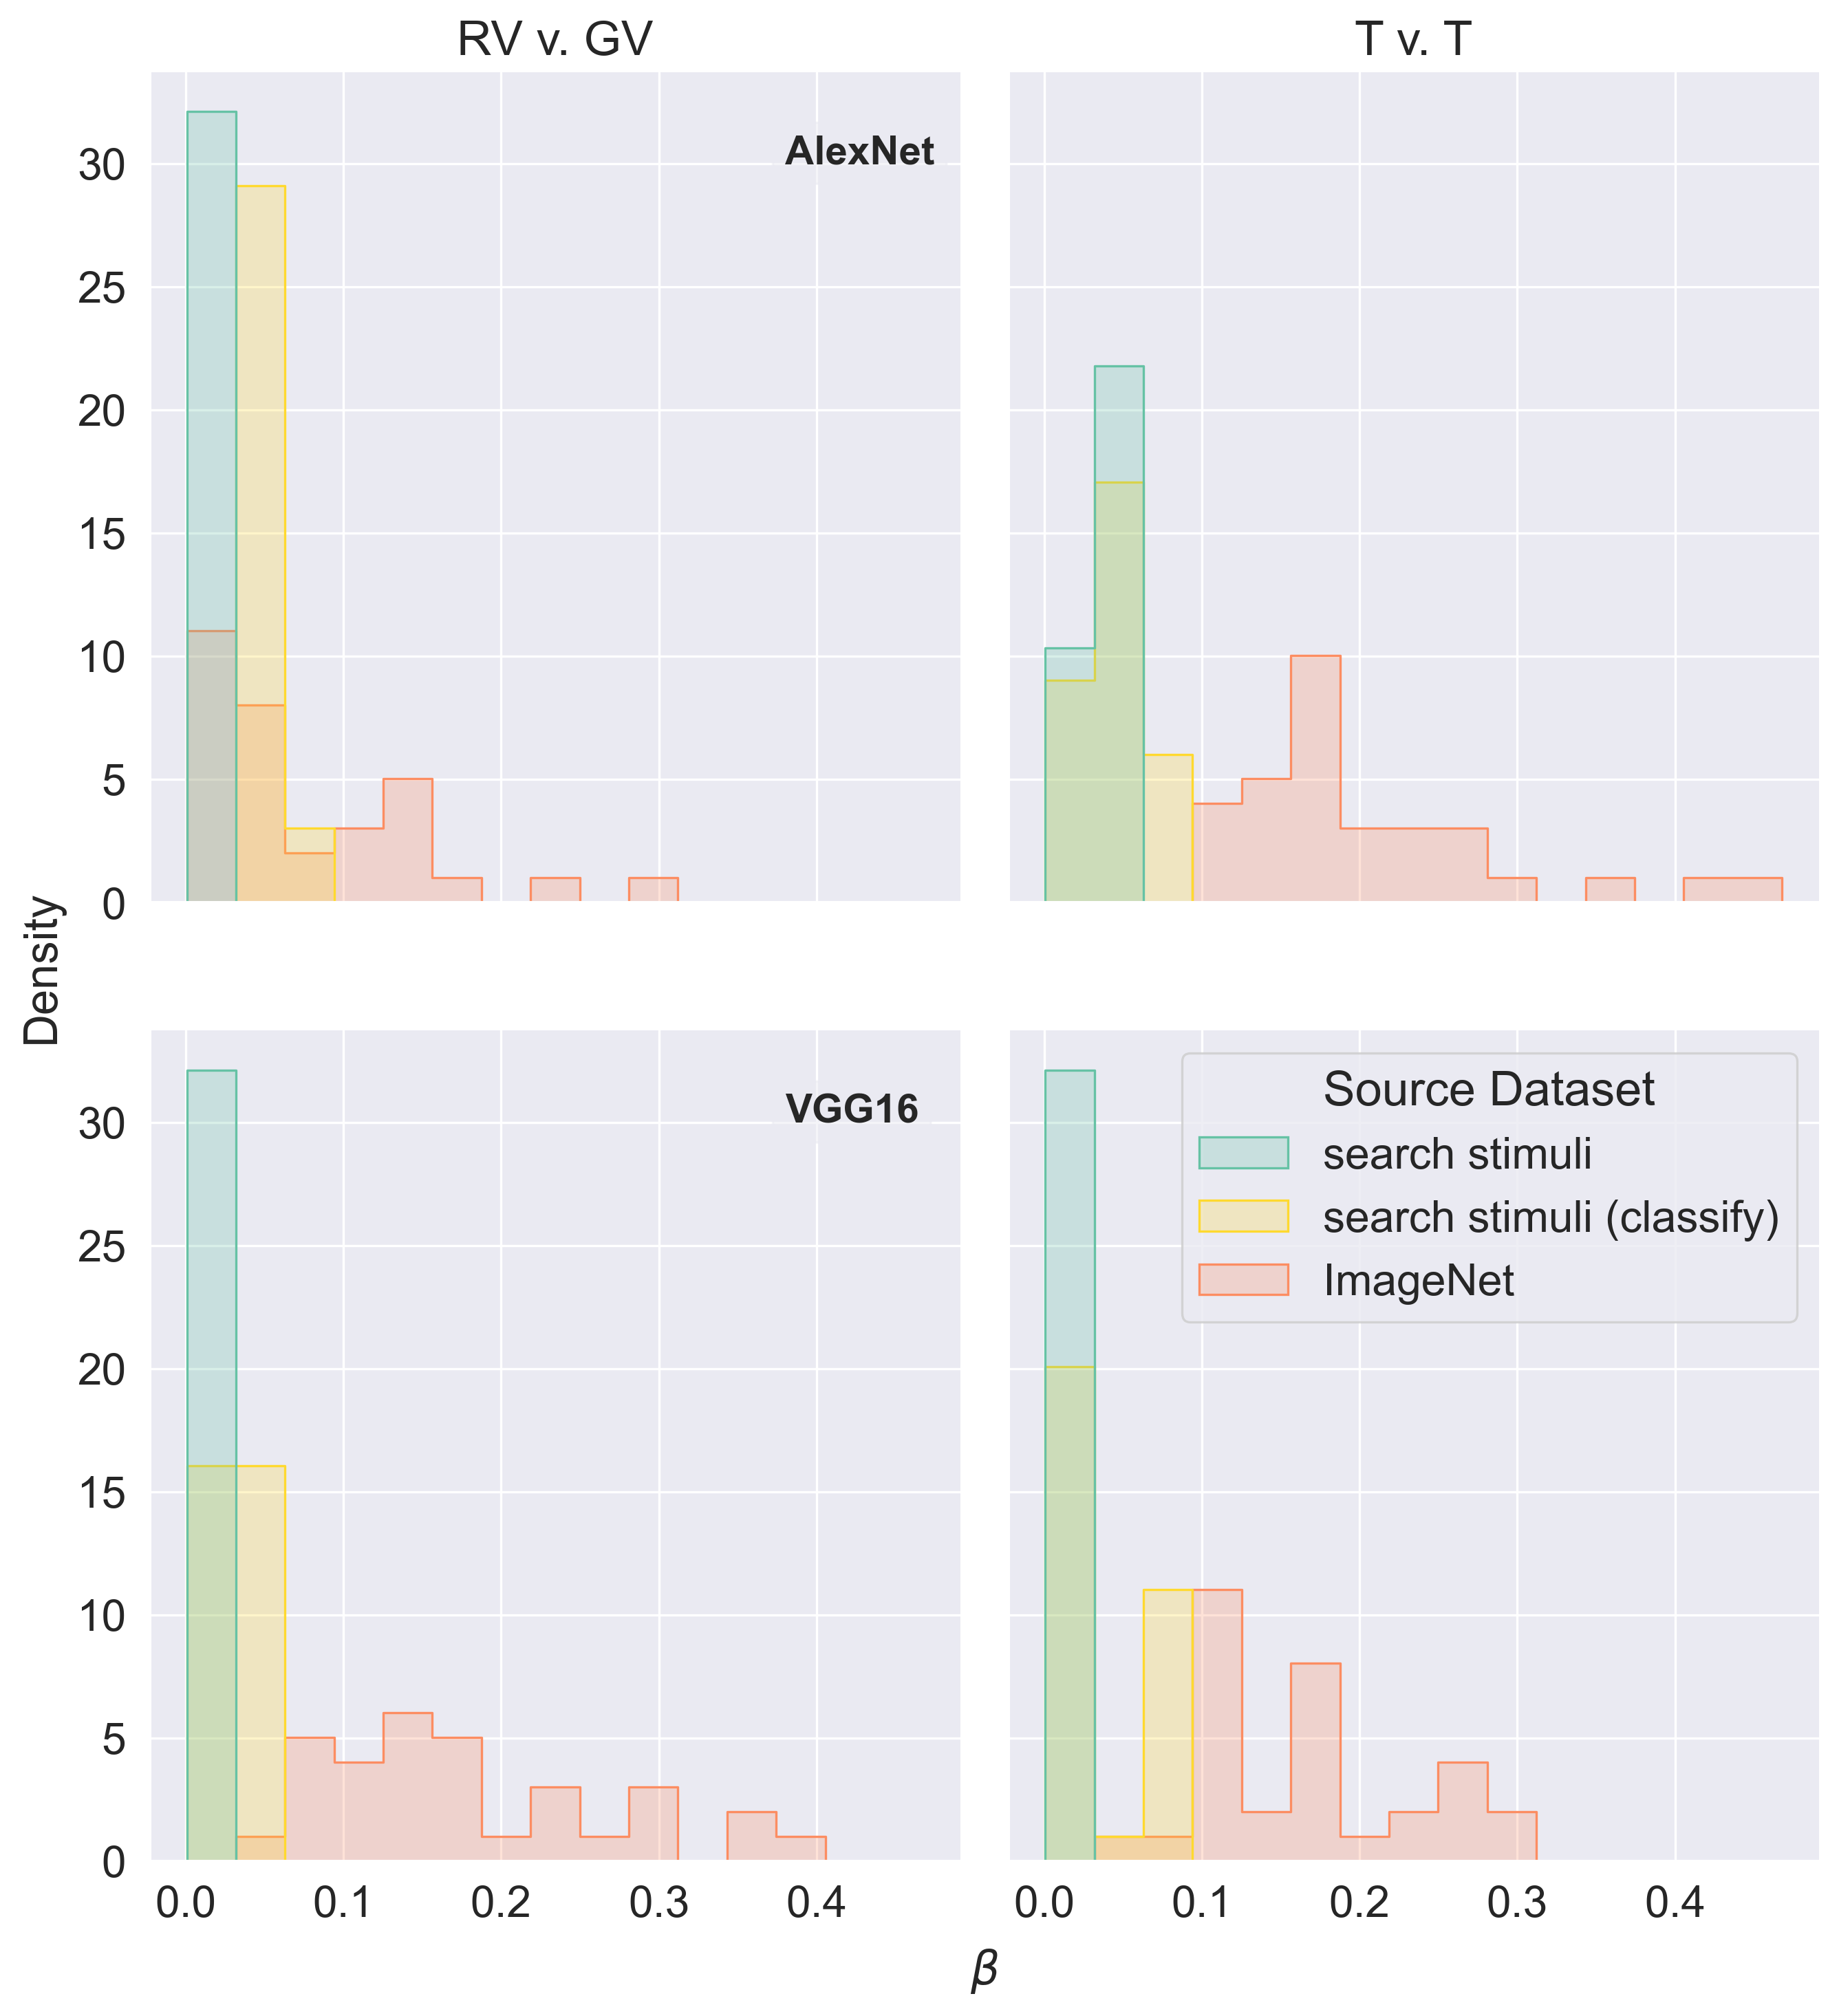

In [27]:


g = sns.displot(
    data=df_all,
    x='beta',
    hue='Source Dataset',
    row='net_name',
    col='stimulus',
    stat="density", 
    common_norm=False,
    element='step',
    palette=palette,
)

for ax in g.fig.axes:
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

for net_name, ax in zip(
    g.row_names,
    (g.fig.axes[0], g.fig.axes[2])
):
    if net_name == 'alexnet':
        net_name = 'AlexNet'
    bbox_kwargs = dict(boxstyle='round', color=ax.get_facecolor(), alpha=0.5)
    h = ax.text(0.38, 30, net_name, fontweight='bold', fontsize=14, bbox=bbox_kwargs)

for stim_name, ax in zip(
    g.col_names,
    (g.fig.axes[0], g.fig.axes[1])
):
    ax.set_title(stim_name)
    
# add a big axis, hide frame
big_ax = g.fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

big_ax.set_ylabel("Density", labelpad=30, fontsize=16);
big_ax.set_xlabel(r"$\beta$", labelpad=30, fontsize=16)

def move_legend(g, ax, new_loc, **kws):
    old_legend = g.legend
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

move_legend(g, g.fig.axes[-2], "upper right")
g.legend.remove()

FIGSIZE = (12, 10)
DPI = 300
g.fig.set_size_inches(FIGSIZE)
g.fig.set_dpi(DPI)

for ext in ('svg', 'png'):
    g.fig.savefig(
        pyprojroot.here() / save_dst / f'beta-params-histogram.{ext}',
        bbox_inches='tight',
    )